# Clustering of metabolite peaks from LC-MS

Incorporating retention time into hierachical clustering of LC-MS peaks.

This was first used in 
Gardinassi et al. (2018) Integrative metabolomics and transcriptomics signatures of clinical tolerance to Plasmodium vivax reveal activation of innate cell immunity and T cell signaling. Redox Biology. DOI: 10.1016/j.redox.2018.04.011

The example below is part of data from the paper.

Shuzhao Li, 2018-05-12

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from scipy.cluster.hierarchy import *
from scipy.spatial.distance import pdist, squareform

infile = "../input_data/HILIC_pos_diag_basel.txt"

In [2]:
metabo = pd.read_table(infile)
print(metabo.shape)
metabo.head()

(4236, 13)


,mz_rt,N1,N2,N3,N4,N5,N6,SI1,SI2,SI3,SI4,SI5,SI6
0,85.02865196_275.3154044,-0.741169,-1.394805,-0.620273,0.857773,-1.613470,-0.264445,-1.909026,-0.187610,1.388254,0.878922,-0.934093,2.638685
1,85.02868748_114.3203084,-2.711312,1.161496,5.581955,-0.188379,-0.081080,0.621589,-0.875584,-0.542016,0.730462,1.173231,0.587078,7.605417
2,85.04799534_127.0756394,-0.059953,-5.980863,-0.026952,0.000000,-21.934977,-0.461426,-1.451391,-0.965788,0.979416,0.767319,-0.773038,-21.085978
3,85.06507359_261.7958538,-0.589275,-0.497958,0.441288,-1.408106,0.203421,-1.705279,-0.614097,-1.570598,0.656213,0.304973,0.163556,0.462155
4,85.07627944_160.8882793,-0.348159,-0.509134,-0.330221,0.701595,0.679800,-2.164348,-0.705403,-1.027574,1.476842,0.516237,-0.505817,1.322065


('min_retention_time, max_retention_time', -26.600752399999998, 27.56155862)
('Vector delta_RT len: ', 8969730)
('Shape of dist matrix, ', (8969730,))


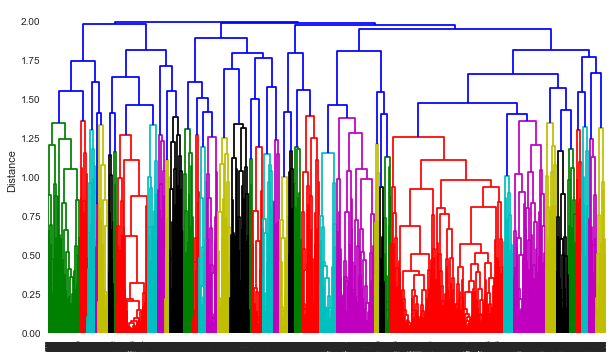

In [3]:
'''
Default input format: m/z  retention_time  samples  
# Scipy implementation of hierarchical clustering is mirroring Matlab
# https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html
# https://www.mathworks.com/help/stats/hierarchical-clustering.html
This adds a function to penalize distance in retention time.
Output includes two figures, dendrogram and heatmap, which can be slow especially in pdf.
Sensitive to missing input data.
'''

# distance matrix, this is [1 - (Pearson R)]
YM = pdist(metabo.values[:, 1:], 'correlation')

retention_time = metabo.values[:,1]
min_retention_time, max_retention_time = min(retention_time), max(retention_time)
range_retention_time = max_retention_time - min_retention_time
print("min_retention_time, max_retention_time", min_retention_time, max_retention_time)

PearsonR = 1 - YM
delta_RT = []
for ii in range(metabo.shape[0]):
    for jj in range(ii+1, metabo.shape[0]):
        delta_RT.append(abs(retention_time[ii] - retention_time[jj]))        

print("Vector delta_RT len: ", len(delta_RT))

#
# weighting function
# distance = 1 - (1 - delta_RT/range_retention_time)*PearsonR
#
YM_new = 1 - (1- np.array(delta_RT)/range_retention_time)*PearsonR

print("Shape of dist matrix, ", YM_new.shape)

# Metabolite features linkage matrix using new distance matrix
ZM = linkage(YM_new, method='complete')

plt.figure(figsize=(10, 6))
#plt.title('HCL HILICpos study xyz')
plt.ylabel('Distance')
dendrogram(ZM)

# use .pdf if desired, but slower
plt.savefig('fig1.png')

/Users/sli/anaconda2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


('number of clusters: ', 31)


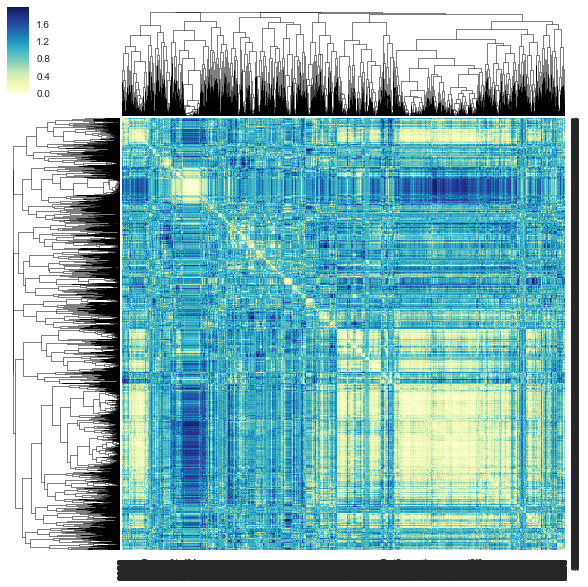

In [4]:
# Based on the dendrogram above, choose
distance_cut=1.5

# do linkage heat map
plt.figure(figsize=(10, 10))
sns.clustermap(squareform(YM_new), row_linkage=ZM, col_linkage=ZM, cmap="YlGnBu")
plt.savefig('fig2.png')

metClus = fcluster(ZM, distance_cut, criterion='distance')
# Compile clusters
metClusDict = {}
for ii in range(len(metClus)):
    if metClusDict.has_key(metClus[ii]):
        metClusDict[ metClus[ii] ].append(ii)
    else:
        metClusDict[ metClus[ii] ] = [ii]

print("number of clusters: ", len(metClusDict.keys()))

In [5]:
# write out clusters. 
def write_cluster(OUTDIR, wanted_clusters, metClus, metabo, prefix="metabo_"):
    for c in wanted_clusters:
        goodrows = []
        for ii in range(metabo.shape[0]):
            if metClus[ii] == c:
                goodrows.append(ii)

        metabo.iloc[goodrows, :].to_csv( OUTDIR + prefix + "clus_%d.txt" %c, sep="\t")

# do all
wanted = metClusDict.keys()
# Need create OUTDIR first
OUTDIR = 'export_clusters/'
os.mkdir(OUTDIR)

write_cluster(OUTDIR, wanted, metClus, metabo, prefix="metabo_")

In [7]:
# to export collapsed values of each cluster, as per sample a = sum(z score)/squareroot(feature number)
def zscore(V):
    # input np array
    V = list(V)
    m, std = np.mean(V), np.std(V)
    return (V-m)/std

def get_cluster_activity(M):
    sqN = np.sqrt(M.shape[0])
    new, new2 = [], []
    for row in M:
        new.append(zscore(row))
    for ii in range(len(row)):
        new2.append(sum([x[ii] for x in new])/sqN)
        
    return new2

def write_cluster_activities(OUTDIR, wanted_clusters, metClus, metabo, prefix="metabo_"):
    '''
    To export collapsed values of each cluster, as per sample a = sum(z score)/squareroot(feature number)
    The columns of m/z and rtime may bet converted but they are meaningless
    '''
    s = 'cluster_number\t' + '\t'.join(list(metabo.columns)) + '\n'
    for c in wanted_clusters:
        goodrows = []
        for ii in range(metabo.shape[0]):
            if metClus[ii] == c:
                goodrows.append(ii)
        # Note values in metabo starts from col 1
        s += prefix+str(c) + '\t' + '\t'.join(
            [str(x) for x in get_cluster_activity(metabo.iloc[goodrows, 1:].values)]) + '\n'

    with open('cluster_activities.txt', 'w') as file:
        file.write(s)

write_cluster_activities('./', wanted, metClus, metabo, prefix="metabo_")

The output cluster activities can be used for further statistical analysis, similarly to feature level analysis.
